# AI-Driven Reconfigurable Intelligent Surface (RIS) Control Using Reinforcement Learning

## Deep Deterministic Policy Gradient (DDPG)-based phase optimization for dynamic 6G wireless environments

### Author: Jay Gautam, February 2026


# AI Agent Problem Statement

This work implements intelligent phase control of Reconfigurable Intelligent Surfaces (RIS) for future 6G wireless networks under dynamic channel conditions. The goal is to maximize spectral efficiency, SNR and reliability (through outage prediction) by formulating RIS control as a model-free reinforcement learning problem, using a DDPG agent to learn continuous phase configurations directly from interaction with the environment. Performance is evaluated in terms of throughput, SNR, and outage probability, and compared against closed-form analytical optimization and no-RIS baselines.

# Resource & Links
GitHub (code, implementations, updates):  
https://github.com/jskgautam


LinkedIn (professional updates and discussions):  
https://www.linkedin.com/in/jay-gautam-203362a2/recent-activity/shares/


# Section 1: Libraries

In [69]:
# Author: Jay Gautam
# Libraries, Import
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import time

# Reproducibility
SEED = 0
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Device choices
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Computing Device:", device)

Computing Device: cuda


# Section 1: Parameters

In [70]:
# Author: Jay Gautam
# Parametrs required for the project
N_ELEMENTS = 16 # Number of RIS Elements
EPISODES = 700 # Number of training episodes
EPISODE_LENGTH = 50 # Length of each training episodes

BATCH_SIZE = 32 # Batch Size for Training
NOISE_POWER = 1e-3 # Noise Power in Watt
RHO = 0.95 # Fading parameter
MOV_WINDOW = 50 # Moving Average Window

EVAL_EPISODES = 100 # Number of episodes for the evaluation process.
OUTAGE_SNR_DB = 0.0 # Threshold for SNR to determine Outage condition. in dB
OUTAGE_SNR_LIN = 10**(OUTAGE_SNR_DB/10) # Threshold for SNR to determine Outage condition. in Linear

# Section 2: RIS Environment for Reinforcement learning (DDPG) Agent
## No Direct link between Base Station and User

In [71]:
# Author: Jay Gautam
# Define a class: RIS Environment for the Agent. Without Direct path. h_sr, h_rd, no h_bd
# With this class. the agent steps and get the reward based on the definition.

class RISEnv:
  # Constructor
  def __init__(self, N = 16, noise_power = 1e-3, rho = 0.95, episode_length = 50):
    self.N = N # number of RIS Elements. NXN Panel
    self.noise_power = noise_power
    self.rho = rho # Temporal relation coefficients. Fading. Dynamic Challel modelling.
    self.episode_length = episode_length
    self.state_dim = 4*N # Real and maginary parts for BS->RIS and RIS->User
    self.action_dim = N # Phase. action dim = number of RIS Elements.
    self.step_count = 0 # Counter

  # Initialize Random channel and reset step counter. Rayleigh model.
  def reset(self):
    self.step_count = 0
    self.h_sr = (np.random.randn(self.N) + 1j*np.random.randn(self.N)) / np.sqrt(2) # BS(s)-> RIS(r)
    self.h_rd = (np.random.randn(self.N) + 1J*np.random.randn(self.N)) / np.sqrt(2) # RIS(r)-> Device(d)
    return self._get_state() # Private function. Hidden for outside users.

  def _get_state(self): # Channel Matrix. Private function. OOP-Polymorphism concept.
    return np.concatenate([np.real(self.h_sr), np.imag(self.h_sr),
                           np.real(self.h_rd), np.imag(self.h_rd)])

  # Rayleigh Cahhel + Fast fading (rho factor) channel. Private function. OOP-Polymorphism concept.
  def _update_channel(self):
    self.h_sr = self.rho*self.h_sr + np.sqrt(1- self.rho**2)*(np.random.randn(self.N) + 1j*np.random.randn(self.N)) / np.sqrt(2)
    self.h_rd = self.rho*self.h_rd + np.sqrt(1- self.rho**2)*(np.random.randn(self.N) + 1j*np.random.randn(self.N)) / np.sqrt(2)

  def step(self, action):
    # Take action
    theta = (action + 1)* np.pi # Phase shift by the element. [0, 2*pi]
    Phi = np.exp(1j*theta) # RIS Phase shift Matrix

    # Get reward for the action
    gain = np.abs(np.dot(self.h_rd.conj().T, Phi * self.h_sr)) ** 2
    snr = gain / self.noise_power
    reward = np.log2(1 + snr/self.N) # Shanons Capacity formula.

    # Get the next state, return done flag and rewrd
    self._update_chnnel()
    self.step_count +=1

    done = self.step_count >= self.episode_length # done flag, if it exceed the episode length.
    next_state = self._get_state() # Get new state (channel)

    return next_state, reward, done, {"snr": snr}


In [72]:
## Debug
env_test = RISEnv()
#env_test.reset()
#env_test.N
# env_test._update_channel() # You can not call it, as it is private. Used only internally.

# Section 3: RIS Environment for Reinforcement learning (DDPG) Agent
## With Direct link between Base Station and User

In [73]:
# Author: Jay Gautam
# Define a class: RIS Environment for the Agent. With Direct path. h_sr, h_rd, h_bd
# With this class. the agent steps and get the reward based on the definition.

class RISEnvFull:
    def __init__(self, N=16, noise_power=1e-3, rho=0.95, episode_length=50):
        self.N = N # number of RIS Elements. NXN Panel
        self.noise_power = noise_power
        self.rho = rho # Temporal relation coefficients. Fading. Dynamic Challel modelling.
        self.episode_length = episode_length
        self.state_dim = 4 * N + 2 # Real and maginary parts for BS->RIS and RIS->User, and BS(b)->User(d)
        self.action_dim = N # Phase. action dim = number of RIS Elements.
        self.step_count = 0 # Counter

    # Initialize Random channel and reset step counter. Rayleigh model.
    def reset(self):
        self.step_count = 0
        self.h_sr = (np.random.randn(self.N) + 1j*np.random.randn(self.N))/np.sqrt(2) # BS(s)-> RIS(r)
        self.h_rd = (np.random.randn(self.N) + 1j*np.random.randn(self.N))/np.sqrt(2) # RIS(r)-> Device(d)
        self.h_bd = (np.random.randn() + 1j*np.random.randn())/np.sqrt(2) # BS(b)->User(d)
        return self._get_state()

    # Channel Matrix
    def _get_state(self):
        return np.concatenate([np.real(self.h_sr), np.imag(self.h_sr),
                               np.real(self.h_rd), np.imag(self.h_rd),
                               np.array([np.real(self.h_bd), np.imag(self.h_bd)])])
    # Rayleigh Cahhel + Fast fading (rho factor) channel. Private function. OOP-Polymorphism concept.
    def _update_channel(self):
        self.h_sr = self.rho * self.h_sr + np.sqrt(1 - self.rho**2) * (
            (np.random.randn(self.N) + 1j * np.random.randn(self.N)) / np.sqrt(2)
        )
        self.h_rd = self.rho * self.h_rd + np.sqrt(1 - self.rho**2) * (
            (np.random.randn(self.N) + 1j * np.random.randn(self.N)) / np.sqrt(2)
        )
        self.h_bd = self.rho * self.h_bd + np.sqrt(1 - self.rho**2) * (
            (np.random.randn() + 1j * np.random.randn()) / np.sqrt(2)
        )

    # Take action and get reward and new state.
    def step(self, action):
        # Take action, phase change.
        theta = (action + 1.0) * np.pi   # theta in [0, 2pi]
        Phi = np.exp(1j * theta)         # element-wise phase shift (length N)

        # Get reward for the action
        reflected = np.dot(self.h_rd.conj().T, Phi * self.h_sr)
        total = self.h_bd + reflected
        gain = np.abs(total)**2
        snr = gain / self.noise_power
        reward = np.log2(1 + snr)  # spectral efficiency per step

        # Get the next state, return done flag and rewrd
        self._update_channel()
        self.step_count += 1
        done = self.step_count >= self.episode_length # done flag, if exceed predefined episode length.
        next_state = self._get_state() # reset the state
        info = {"snr": snr, "gain": gain, "reflected": np.abs(reflected)**2, "direct": np.abs(self.h_bd)**2}
        return next_state, reward, done, info


# Section 4: Actor–Critic Architecture for Continuous RIS Control (DDPG)

In [74]:
# Author: Jay Gautam
# Actor-Critic Network: Policy netw
# Condition for stable training: Initialize weight and bias
# .. for linear network using Xavier function.
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.constant_(layer.bias, 0.0)

# Policy network: States to Action- to find RIS phases.
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=256):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, action_dim)
        self.apply(init_weights)
    def forward(self, s): # states as input, action as output
        x = F.relu(self.fc1(s))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

# Q-Value network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=256):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
        self.apply(init_weights)
    def forward(self, s, a): # States and Actions as input. Q-value for (s,a) pair as output.
        x = torch.cat([s, a], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# Section 5: DDPG Agent Design and Learning Mechanism

In [75]:
# Author: Jay Gautam
# Deep Deterministic Policy Gradient (DDPG) Agent
# DDPG Agent (Model Free) learns purely based on experinece
## actor, actor_target, actor_opt
## critc, critic_target, critic_opt
class DDPGAgent:
    def __init__(self, state_dim, action_dim, device):
        self.device = device
        self.actor = Actor(state_dim, action_dim).to(device) # actor
        self.actor_target = Actor(state_dim, action_dim).to(device) # actor target
        self.actor_target.load_state_dict(self.actor.state_dict()) # actor target

        self.critic = Critic(state_dim, action_dim).to(device) # Critic
        self.critic_target = Critic(state_dim, action_dim).to(device) # Critic Target
        self.critic_target.load_state_dict(self.critic.state_dict()) # Critic Target

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=1e-4) # Actor: Adam optimizer
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=1e-3) # Critic: Adam Optimizer
        self.buffer = deque(maxlen=100000) # Experience replay buffer, size = maxlen
        self.gamma = 0.99 # Discount factor
        self.tau = 0.005 # Polyak averaging parameter

    def select_action(self, state, noise_scale=0.02):
        s = torch.FloatTensor(state.reshape(1, -1)).to(self.device)# state tensor data type
        a = self.actor(s).cpu().data.numpy().flatten()  # action tensor data type
        # Add Gaussian noise to the action for more exploration
        a += np.random.normal(0, noise_scale, size=a.shape)
        return np.clip(a, -1, 1) # Return the Clipped action (bounded value)

    # Experience replay buffer. Store the Transitions.
    def store(self, transition):
        self.buffer.append(transition)

    def train(self, batch_size=64):
        if len(self.buffer) < batch_size: # check the sufficient memory size for training
            return
        s, a, r, s2, d = map(np.stack, zip(*random.sample(self.buffer, batch_size)))# extract RL elements
        s, a, r, s2, d = [torch.FloatTensor(x).to(self.device)
                          for x in [s, a, r.reshape(-1, 1), s2, d.reshape(-1, 1)]] # Tensor form data

        with torch.no_grad():
            next_a = self.actor_target(s2)
            target_Q = r + (1 - d) * self.gamma * self.critic_target(s2, next_a) # Bellman Equation
        # Critic Network Update
        loss_c = F.mse_loss(self.critic(s, a), target_Q)
        self.critic_opt.zero_grad(); loss_c.backward(); self.critic_opt.step()

        # Actor Network Update
        loss_a = -self.critic(s, self.actor(s)).mean()
        self.actor_opt.zero_grad(); loss_a.backward(); self.actor_opt.step()

        # Soft update of actor/critic target networks- Polyak averaging.
        for net, tgt in [(self.actor, self.actor_target), (self.critic, self.critic_target)]:
            for p, tp in zip(net.parameters(), tgt.parameters()):
                tp.data.copy_(self.tau * p.data + (1 - self.tau) * tp.data)


# Section 6: Closed Form Phase Optimization: Analytical Approach (Baseline Methods for Performance Comparison)

In [76]:
# Author: Jay Gautam
# Closed-form implementation: Analytical function- to compare with DDPG agent
## Analytical implementation: RIS Phase tuning. BS-> RIS, RIS->Device
def closed_form_action_from_channels(h_sr, h_rd):
    theta = np.angle(h_rd) - np.angle(h_sr)
    theta = np.mod(theta, 2*np.pi)
    a = theta / np.pi - 1.0
    return np.clip(a, -1.0, 1.0) # used to find analytical phase shift matrix.


# Section 7: Evaluation Module: Closed Form Phase Optimization: Analytical Approach

In [77]:
# Author Jay Gautam
# Analysis and Evaluation of the Closed Form Imlementation.
# It will return Throughput, SNR and Outage count value.

def evaluate_closed_form(env, episodes=200):
    througputs = [] # KPI
    snrs_db = []
    outages = [] # KPI: Outage Probability
    for ep in range(episodes):
        _ = env.reset() # Get envitonment parameters, based on the choice.
        ep_th = 0.0
        ep_snrs = []
        ep_outage_count = 0
        for _step in range(env.episode_length):
            a = closed_form_action_from_channels(env.h_sr, env.h_rd) # Action
            _, r, _, info = env.step(a) # Step in the environment with action value "a", get reward
            ep_th += r
            snr = float(info["snr"])
            ep_snrs.append(snr)
            if snr < OUTAGE_SNR_LIN: # Check for Outage with the defined threshold value.
                ep_outage_count += 1 # Outage counter.
        througputs.append(ep_th / env.episode_length) # throughput append
        snrs_db.append(10*np.log10(np.maximum(1e-12, np.mean(ep_snrs)))) # snr append
        outages.append(ep_outage_count / env.episode_length) # outage count append
    return np.array(througputs), np.array(snrs_db), np.array(outages)


# Step 8: Evaluation Module: no-RIS scenarios- Direct link between BS and User

In [78]:
# Author Jay Gautam
# Analysis and Evaluation: Case when no RIS is used in the communication.
# .. Base station and the user. Direct Channel.
# It will return Throughput, SNR and Outage count value.

def evaluate_noRIS(env, episodes=200):
    # Use only direct link; still evolve channels like env does
    througputs = []
    snrs_db = []
    outages = []
    for ep in range(episodes):
        _ = env.reset()
        ep_th = 0.0
        ep_snrs = []
        ep_outage_count = 0
        for _step in range(env.episode_length):
            gain = np.abs(env.h_bd)**2 # Based on direct channel BS->UserDevice
            snr = gain / env.noise_power
            r = np.log2(1 + snr)
            ep_th += r
            ep_snrs.append(snr)
            if snr < OUTAGE_SNR_LIN: # Count Outage
                ep_outage_count += 1
            env._update_channel()
        througputs.append(ep_th / env.episode_length)
        snrs_db.append(10*np.log10(np.maximum(1e-12, np.mean(ep_snrs))))
        outages.append(ep_outage_count / env.episode_length)
    return np.array(througputs), np.array(snrs_db), np.array(outages)


# Section 9: Evaluation Module: DDPG Agent

In [79]:
# Author Jay Gautam
# Evaluation Module: Perfomrmance with DDPG Agent
# It will return Throughput, SNR and Outage count value.
def evaluate_agent(env, agent, episodes=200, device='cpu'):
    througputs = []
    snrs_db = []
    outages = []
    for ep in range(episodes):
        s = env.reset()
        ep_th = 0.0
        ep_snrs = []
        ep_outage_count = 0
        done = False # Done flag- check- copleted or not completed
        while not done:
            a = agent.select_action(s, noise_scale=0.0) # DDPG Agents action
            s2, r, done, info = env.step(a) # DDPG steps to the environment with the action "a"
            ep_th += r
            snr = float(info["snr"])
            ep_snrs.append(snr)
            if snr < OUTAGE_SNR_LIN:
                ep_outage_count += 1
            s = s2 # update state.
        througputs.append(ep_th / env.episode_length) # Append throughput
        snrs_db.append(10*np.log10(np.maximum(1e-12, np.mean(ep_snrs)))) # Append SNR
        outages.append(ep_outage_count / env.episode_length) # Append Outage count
    return np.array(througputs), np.array(snrs_db), np.array(outages)


# Section 10: Training: DDPG Agent on RIS assisted communication and Direct link
## Logging for: SNR, Critics Learning statistics, Throughput and Outage

In [80]:
# Author Jay Gautam
# Training DDPG on RISEnvFull- All three Channels.

env = RISEnvFull(N=N_ELEMENTS, episode_length=EPISODE_LENGTH, rho=RHO, noise_power=NOISE_POWER)
agent = DDPGAgent(env.state_dim, env.action_dim, device)

# Evaluation Metrics using DDPG
reward_history = []
accumulated_reward_history = [] # Reward accumulation over episodes
snr_history = []
critic_q_history = [] # Q-value of the Critic Network
throughput_history = []
outage_history = []

start_time = time.time()
for ep in range(EPISODES): # Start the training with the episodes
    s = env.reset() # reset the state in the start of new episodes
    ep_reward = 0.0
    ep_snr_list = []
    q_values_in_episode = []
    ep_throughput = 0.0
    ep_outage_count = 0

    while True:
        a = agent.select_action(s) # take action with the state (s = Channel)
        with torch.no_grad():
            s_t = torch.FloatTensor(s.reshape(1, -1)).to(device)
            a_t = torch.FloatTensor(a.reshape(1, -1)).to(device)
            q_val = agent.critic(s_t, a_t).cpu().item() # Q value from the Value Network.
            q_values_in_episode.append(q_val) # Q value append

        s2, r, done, info = env.step(a)
        snr = float(info["snr"]) # get snr from the info flag

        ep_throughput += np.log2(1.0 + snr)
        if snr < OUTAGE_SNR_LIN: # Outage counter test
            ep_outage_count += 1

        agent.store((s, a, r, s2, float(done))) # Replay Buffer
        agent.train(BATCH_SIZE)

        ep_reward += r
        ep_snr_list.append(snr)
        s = s2 # State update
        if done: # done flag check
            break

    # Per episode: Update metrics/KPI
    reward_history.append(ep_reward / env.episode_length)
    accumulated_reward_history.append(ep_reward)
    snr_history.append(np.mean(ep_snr_list) if ep_snr_list else 0.0)
    critic_q_history.append(np.mean(q_values_in_episode) if q_values_in_episode else 0.0)
    throughput_history.append(ep_throughput / env.episode_length)
    outage_history.append(ep_outage_count / env.episode_length)

    # Display Training progress data
    if (ep + 1) % 50 == 0 or ep == 0:
        elapsed = time.time() - start_time # Totl time of the training.
        print(f"Episode {ep+1}/{EPISODES} | Avg Reward={reward_history[-1]:.4f} | "
              f"Avg SNR={10*np.log10(np.maximum(1e-12, snr_history[-1])):.2f} dB | "
              f"Mean Q={critic_q_history[-1]:.3f} | "
              f"Throughput={throughput_history[-1]:.3f} | Outage={outage_history[-1]:.3f} | Training_time={elapsed:.1f}s")

print("Training done. Total Training time: {:.1f}s".format(time.time()-start_time))


Episode 1/700 | Avg Reward=13.5370 | Avg SNR=42.69 dB | Mean Q=2.760 | Throughput=13.537 | Outage=0.000 | Training_time=0.1s
Episode 50/700 | Avg Reward=13.5321 | Avg SNR=42.28 dB | Mean Q=139.432 | Throughput=13.532 | Outage=0.000 | Training_time=14.5s
Episode 100/700 | Avg Reward=14.1259 | Avg SNR=44.41 dB | Mean Q=250.101 | Throughput=14.126 | Outage=0.000 | Training_time=29.3s
Episode 150/700 | Avg Reward=14.1153 | Avg SNR=43.92 dB | Mean Q=440.394 | Throughput=14.115 | Outage=0.000 | Training_time=44.3s
Episode 200/700 | Avg Reward=11.8245 | Avg SNR=38.07 dB | Mean Q=463.089 | Throughput=11.824 | Outage=0.000 | Training_time=58.8s
Episode 250/700 | Avg Reward=13.9177 | Avg SNR=43.01 dB | Mean Q=603.115 | Throughput=13.918 | Outage=0.000 | Training_time=73.3s
Episode 300/700 | Avg Reward=14.0730 | Avg SNR=43.54 dB | Mean Q=866.523 | Throughput=14.073 | Outage=0.000 | Training_time=88.1s
Episode 350/700 | Avg Reward=12.9527 | Avg SNR=41.62 dB | Mean Q=849.582 | Throughput=12.953 | O

# Section 11: Visualization
## Reward vs Episodes
## Average Spectral efficiency vs Episode
## Mean Critic_Q_value vs Episode
## Average SNR (dB) vs Episode

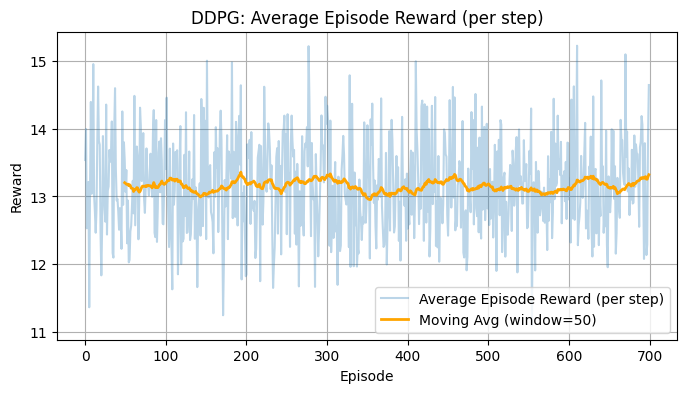

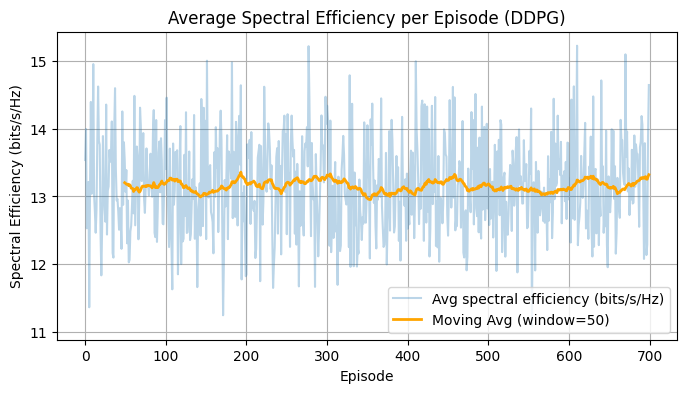

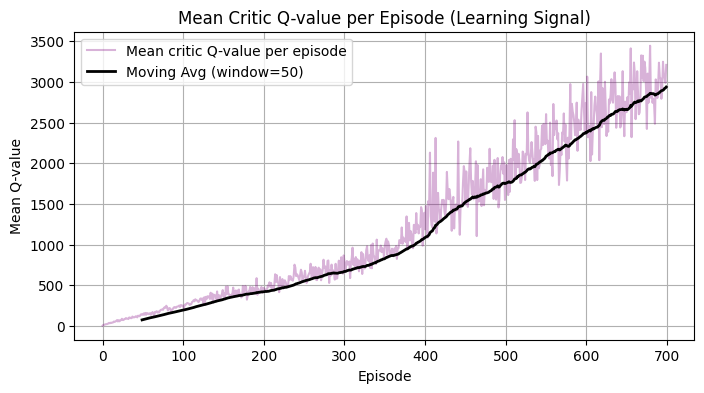

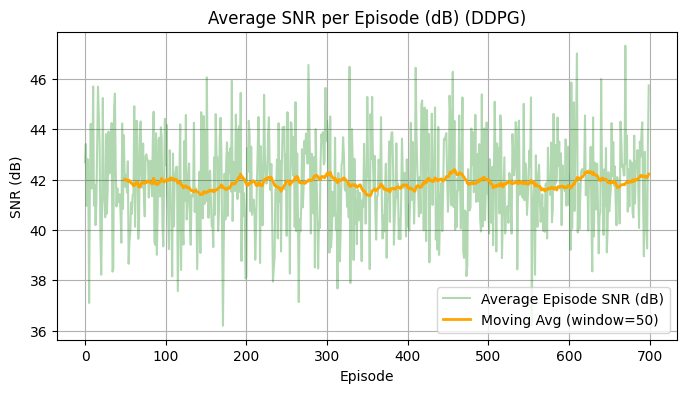

In [81]:
# Author: Jay Gautam
# Visualization: Reward, Average Spectral efficiency, Mean Critic_Q_value and Average SNR (dB)
# Get the average of the metrics in a certain training window.

def moving_avg_with_alignment(x, window): # window-> size of the window.
    y = np.array(x)
    n = len(y)
    x_raw = np.arange(n)
    if n == 0:
        return x_raw, y, np.array([]), np.array([])
    if n >= window and window > 0:
        mov = np.convolve(y, np.ones(window)/window, mode='valid')
        x_mov = np.arange(window-1, n)
        return x_raw, y, x_mov, mov
    else:
        cma = np.cumsum(y) / (np.arange(n) + 1)
        x_mov = x_raw
        return x_raw, y, x_mov, cma


# Average Episode Reward (per step)- average of the window.
# Plot raw reward and moving average reward
x_raw, y_raw, x_mov, y_mov = moving_avg_with_alignment(reward_history, MOV_WINDOW)
plt.figure(figsize=(8,4))
plt.plot(x_raw, y_raw, alpha=0.3, label='Average Episode Reward (per step)')
if len(x_mov) > 0:
    plt.plot(x_mov, y_mov, color='orange', linewidth=2, label=f'Moving Avg (window={MOV_WINDOW})')
plt.title("DDPG: Average Episode Reward (per step)")
plt.xlabel("Episode"); plt.ylabel("Reward")
plt.grid(True); plt.legend(); plt.show()

# Average Spectral Efficiency per Episode
# Plot: Raw spectrum effiiency and averaged spectral efficiency over a window
# It should be same as rewardplot- as Shanon capacity is chosen as reward function.
x_raw, y_raw, x_mov, y_mov = moving_avg_with_alignment(throughput_history, MOV_WINDOW)
plt.figure(figsize=(8,4))
plt.plot(x_raw, y_raw, alpha=0.3, label='Avg spectral efficiency (bits/s/Hz)')
if len(x_mov) > 0:
    plt.plot(x_mov, y_mov, color='orange', linewidth=2, label=f'Moving Avg (window={MOV_WINDOW})')
plt.title("Average Spectral Efficiency per Episode (DDPG)")
plt.xlabel("Episode"); plt.ylabel("Spectral Efficiency (bits/s/Hz)")
plt.grid(True); plt.legend(); plt.show()

# Mean Critic Q-value per Episode- Indicates Learning characteristic of the Critic network
x_raw, y_raw, x_mov, y_mov = moving_avg_with_alignment(critic_q_history, MOV_WINDOW)
plt.figure(figsize=(8,4))
plt.plot(x_raw, y_raw, alpha=0.3, label='Mean critic Q-value per episode', color='purple')
if len(x_mov) > 0:
    plt.plot(x_mov, y_mov, color='black', linewidth=2, label=f'Moving Avg (window={MOV_WINDOW})')
plt.title("Mean Critic Q-value per Episode (Learning Signal)")
plt.xlabel("Episode"); plt.ylabel("Mean Q-value")
plt.grid(True); plt.legend(); plt.show()

# Average SNR (dB) per Episode
snr_db = 10 * np.log10(np.maximum(1e-12, np.array(snr_history)))
x_raw, y_raw, x_mov, y_mov = moving_avg_with_alignment(snr_db.tolist(), MOV_WINDOW)
plt.figure(figsize=(8,4))
plt.plot(x_raw, y_raw, alpha=0.3, label='Average Episode SNR (dB)', color='green')
if len(x_mov) > 0:
    plt.plot(x_mov, y_mov, color='orange', linewidth=2, label=f'Moving Avg (window={MOV_WINDOW})')
plt.title("Average SNR per Episode (dB) (DDPG)")
plt.xlabel("Episode"); plt.ylabel("SNR (dB)")
plt.grid(True); plt.legend(); plt.show()


# Section 12: Evaluation of diferent startegies on the same environment.
## DDPG Agent, Closed-form, no-RIS

In [82]:
# Author Jay Gautam
# Evaluation of diferent startegies on the same environment.
## Evaluates.. DDPG Agent, Closed-form, no-RIS
# Env-> RISEnvFull: Contains all three channels.

print("Evaluation Process..")
eval_env = RISEnvFull(N=N_ELEMENTS, episode_length=EPISODE_LENGTH, rho=RHO, noise_power=NOISE_POWER)

t0 = time.time()
ddpg_th, ddpg_snr_db, ddpg_out = evaluate_agent(eval_env, agent, episodes=EVAL_EPISODES, device=device)
cf_th, cf_snr_db, cf_out = evaluate_closed_form(eval_env, episodes=EVAL_EPISODES)
nr_th, nr_snr_db, nr_out = evaluate_noRIS(eval_env, episodes=EVAL_EPISODES)
print("Evaluation done in {:.1f}s".format(time.time() - t0)) # Time calculator


Evaluation Process..
Evaluation done in 3.1s


# Section 13: Numerical Results
## Throughput, SNR and Outage: DDPG, Closed_form, no-RIS

In [83]:
# Jay Gautam
# Numerical Results: Throughput, SNR and Outage
#.. for DDPG, Closed_form, no-RIS
# Calculate the mean and std of the metrics: different methods

def summary_stats(arr):
    return np.mean(arr), np.std(arr)

methods = ["DDPG (RL)", "Closed-form", "No-RIS"]
means_th = [summary_stats(ddpg_th), summary_stats(cf_th), summary_stats(nr_th)]
means_snr = [summary_stats(ddpg_snr_db), summary_stats(cf_snr_db), summary_stats(nr_snr_db)]
means_out = [summary_stats(ddpg_out), summary_stats(cf_out), summary_stats(nr_out)]

print("\nNumeric summary (over {} eval episodes):".format(EVAL_EPISODES))
for i, m in enumerate(methods):
    print(f"{m}: Throughput mean={means_th[i][0]:.4f} ± {means_th[i][1]:.4f} bits/s/Hz, "
          f"SNR mean={means_snr[i][0]:.2f} ± {means_snr[i][1]:.2f} dB, "
          f"Outage fraction={means_out[i][0]:.3f} ± {means_out[i][1]:.3f}")



Numeric summary (over 100 eval episodes):
DDPG (RL): Throughput mean=13.1335 ± 0.6882 bits/s/Hz, SNR mean=41.85 ± 1.81 dB, Outage fraction=0.000 ± 0.000
Closed-form: Throughput mean=17.2309 ± 0.3636 bits/s/Hz, SNR mean=52.14 ± 1.08 dB, Outage fraction=0.000 ± 0.000
No-RIS: Throughput mean=9.2635 ± 0.9347 bits/s/Hz, SNR mean=29.70 ± 2.44 dB, Outage fraction=0.001 ± 0.004


In [84]:
# methods = ["DDPG (RL)", "Closed-form", "No-RIS"]
# for i, m in enumerate(methods):
#   #print(i, m)
#   print(m, i)


# Section 14: 6G KPI: Visualization
## Bar Plot: Throughput, SNR (dB), Outage

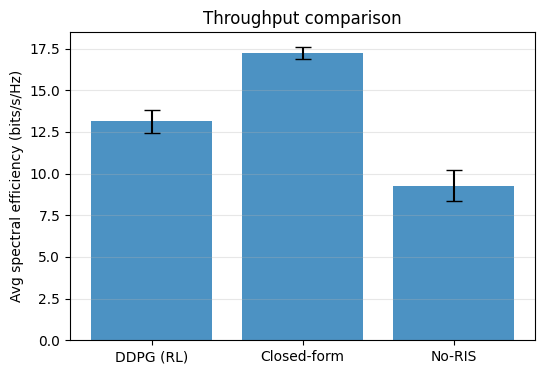

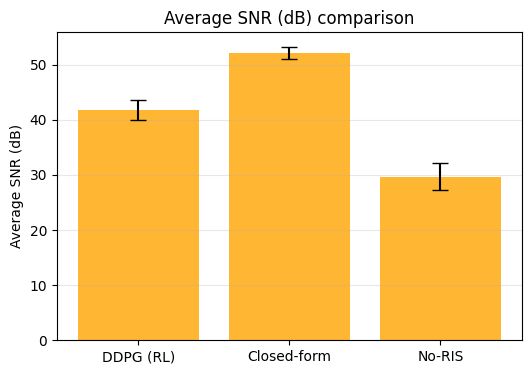

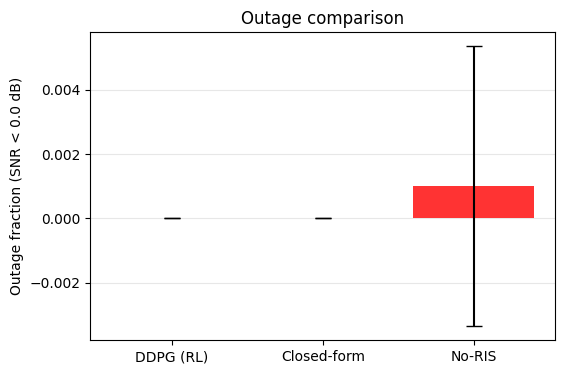

In [86]:
# Jay Gautam
# 6G KPI- Bar Plot: Throughput, SNR (dB), Outage

# Bar plot: throughputs by three methods- DDPG, Closed_form, no-RIS
plt.figure(figsize=(6,4))
x = np.arange(len(methods))
means = [means_th[i][0] for i in range(len(methods))]
stds = [means_th[i][1] for i in range(len(methods))]

plt.bar(x, means, yerr=stds, capsize=6, alpha=0.8)
plt.xticks(x, methods)
plt.ylabel("Avg spectral efficiency (bits/s/Hz)")
plt.title("Throughput comparison")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Bar plot: SNR (dB) by three methods- DDPG, Closed_form, no-RIS
plt.figure(figsize=(6,4))
smeans = [means_snr[i][0] for i in range(len(methods))]
sstds = [means_snr[i][1] for i in range(len(methods))]
plt.bar(x, smeans, yerr=sstds, capsize=6, color='orange', alpha=0.8)
plt.xticks(x, methods)
plt.ylabel("Average SNR (dB)")
plt.title("Average SNR (dB) comparison")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Bar plot: outage by three methods- DDPG, Closed_form, no-RIS
plt.figure(figsize=(6,4))
omeans = [means_out[i][0] for i in range(len(methods))]
ostds = [means_out[i][1] for i in range(len(methods))]
plt.bar(x, omeans, yerr=ostds, capsize=6, color='red', alpha=0.8)
plt.xticks(x, methods)
plt.ylabel("Outage fraction (SNR < {:.1f} dB)".format(OUTAGE_SNR_DB))
plt.title("Outage comparison")
plt.grid(axis='y', alpha=0.3)
plt.show()
